#Config

In [1]:
!pip install transformers==2.6.0

     |████████████████████████████████| 542kB 3.3MB/s 
     |████████████████████████████████| 1.1MB 19.2MB/s 
     |████████████████████████████████| 3.7MB 25.0MB/s 
     |████████████████████████████████| 890kB 25.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=d946f20e34313d19cffb8a31c71bb0fa283adcdc7adf87647124d89907f8b465
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
!pip install fairseq

     |████████████████████████████████| 307kB 3.4MB/s 
     |████████████████████████████████| 61kB 6.0MB/s 
  Created wheel for fairseq: filename=fairseq-0.9.0-cp36-cp36m-linux_x86_64.whl size=2035365 sha256=bedcca73601b0137b150bd46512eb81e629363c480e872af83de92ea963dc595
  Stored in directory: /root/.cache/pip/wheels/37/3e/1b/0fa30695dcba41e4b0088067fa40f3328d1e8ee78c22cd4766
Successfully built fairseq


In [3]:
!pip install fastBPE

  Created wheel for fastBPE: filename=fastBPE-0.1.0-cp36-cp36m-linux_x86_64.whl size=479246 sha256=c7220b03b25dd05935ba7b5f0d5810a621e113470a8f5d6c87066788c8501595
  Stored in directory: /root/.cache/pip/wheels/f3/0c/9c/fc62058b4d473a5602bcd3d3edfece796f123875379ea82d79
Successfully built fastBPE


In [4]:
!pip install seqeval

  Created wheel for seqeval: filename=seqeval-0.0.12-cp36-none-any.whl size=7424 sha256=33b2b9104c8d311c335e3e27419dbcc91eae8c4efaef45874d3de710236b2328
  Stored in directory: /root/.cache/pip/wheels/4f/32/0a/df3b340a82583566975377d65e724895b3fad101a3fb729f68
Successfully built seqeval


In [5]:
import torch
import argparse
import numpy as np
import matplotlib.pyplot as plt
import transformers
import pandas as pd

from torch import nn
from torch.utils.data import DataLoader, RandomSampler, TensorDataset, SequentialSampler

from fairseq.data.encoders.fastbpe import fastBPE
from fairseq.data import Dictionary

from transformers import RobertaConfig, RobertaForTokenClassification
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tqdm.notebook import trange
from seqeval.metrics import f1_score

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
MAX_LEN = 60
batch_sz = 16
epochs = 5
max_grad_norm = 1.0

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
print('{}: {}'.format(device, n_gpu))

#Load Data


**Read Data**

In [12]:
data = pd.read_csv('/content/drive/My Drive/data/ner_products_bio.csv', header=None,
                   sep='\t', encoding='utf8', names=['Sentence#', 'Word', 'Tag'])
data.head(10)

,Sentence#,Word,Tag
0,1,Nhưng,O
1,1,hiện_tại,O
2,1,bạn,O
3,1,đang,O
4,1,cho,O
5,1,bé,O
6,1,bú,O
7,1,nên,O
8,1,bạn,O
9,1,không,O


In [13]:
tuple_func = lambda f: [(w, t) for w, t in zip(f['Word'].values, f['Tag'].values)]
sentences_with_tag = data.groupby('Sentence#').apply(tuple_func)
print(sentences_with_tag)
sentences_with_tag = [sent for sent in sentences_with_tag]

Sentence#
1       [(Nhưng, O), (hiện_tại, O), (bạn, O), (đang, O...
2                        [(Áo, B-pr), (Hm, I-pr), (ạ, O)]
3       [(Cho, O), (mình, O), (đặt, O), (cái, O), (bal...
4       [(Ac, O), (có, O), (vest, B-pr), (chưa, O), (?...
5       [(body, B-pr), (lotion, I-pr), (e, O), (lại, O...
                              ...                        
2517    [(Mình, O), (có, O), (s10, B-pr), (plus, I-pr)...
2518    [(Shop, O), (còn, O), (cho, O), (đổi, O), (Sam...
2519    [(Đã, O), (bao_gồm, O), (trợ_giá, O), (với, O)...
2520    [(Chỉ, O), (nứt, O), (một, O), (đường, O), (tr...
2521    [(Lúc, O), (sáng, O), (e, O), (có, O), (hỏi, O...
Length: 2521, dtype: object


In [14]:
sentences = [' '.join([word[0] for word in sent]) for sent in sentences_with_tag]
sentences[1]

'Áo Hm ạ'

In [15]:
labels = [[word[1] for word in sent] for sent in sentences_with_tag]
labels[1]

['B-pr', 'I-pr', 'O']

In [16]:
labels_value = ['B-pr','I-pr','O', 'PAD', '[CLS]', '[SEP]', 'X']
label2idx = {label:indx for indx, label in enumerate(labels_value)}
label2idx

{'B-pr': 0, 'I-pr': 1, 'O': 2, 'PAD': 3, 'X': 6, '[CLS]': 4, '[SEP]': 5}

***Encode with bpe***

In [0]:
parser = argparse.ArgumentParser()
parser.add_argument('--bpe-codes', 
    default="/content/drive/My Drive/pre_model/phobert/PhoBERT_base_transformers/bpe.codes",
    required=False,
    type=str,  
    help='path to fastBPE BPE'
)
args, unknown = parser.parse_known_args()

bpe = fastBPE(args)

In [18]:
subwords = ['<s> '+bpe.encode(sent)+' </s>' for sent in sentences]
subwords[1] 

'<s> Áo H@@ m ạ </s>'

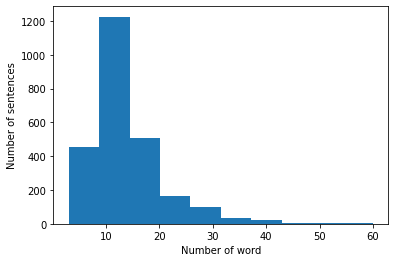

In [19]:
plt.hist([len(s.split()) for s in subwords])
plt.xlabel('Number of word')
plt.ylabel('Number of sentences')
plt.show()

***Change labels by subword***

In [0]:
label_subwords = []
for i in range(len(subwords)):
  indx = 0
  label = ['[CLS]']
  for word in subwords[i].split()[1:MAX_LEN-1]:
    if word == '</s>':
      break
    if '@@' not in word:
      label.append(labels[i][indx])
      indx += 1
      continue
    label.append('X')
  label.append('[SEP]')
  label_subwords.append(label) 
      

In [21]:
label_subwords[1]

['[CLS]', 'B-pr', 'X', 'I-pr', 'O', '[SEP]']

***String to number***

In [0]:
vocab = Dictionary()
vocab.add_from_file("/content/drive/My Drive/pre_model/phobert/PhoBERT_large_transformers/dict.txt")

In [0]:
input_ids = pad_sequences([vocab.encode_line(sent, append_eos=False, add_if_not_exist=False).long().tolist() for sent in subwords],
                          truncating='post', padding='post', maxlen=MAX_LEN, value=1.0, dtype='long')

In [24]:
input_ids[1]

array([   0, 3759, 1125,  599, 3628,    2,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1])

In [25]:
labels_ids = pad_sequences([[label2idx.get(label) for label in labels] for labels in label_subwords], dtype='long',
                            maxlen=MAX_LEN, value=label2idx['PAD'], truncating='post', padding='post')
labels_ids[1]

array([4, 0, 6, 1, 2, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [0]:
attenion_mask = [[float(val != 1) for val in sent] for sent in input_ids]

***Create train/validation data***

In [0]:
X_train, X_val, y_train, y_val = train_test_split(input_ids, labels_ids, random_state=96, test_size=0.2)
train_mask, val_mask, _, _ = train_test_split(attenion_mask, input_ids, random_state=96, test_size=0.2)

In [0]:
# change to tensor
X_train = torch.tensor(X_train)
X_val = torch.tensor(X_val)
y_train = torch.tensor(y_train)
y_val = torch.tensor(y_val)
train_mask = torch.tensor(train_mask)
val_mask = torch.tensor(val_mask)

In [0]:
#create data loader
train_data = TensorDataset(X_train, train_mask, y_train)
train_sample = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sample, batch_size=batch_sz)

val_data = TensorDataset(X_val, val_mask, y_val)
val_sample = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sample, batch_size=batch_sz)

In [30]:
val_data[1]

(tensor([    0, 13072,    68,   202,   188, 27481,  1187, 15654,     2,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1]),
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.]),
 tensor([4, 2, 2, 2, 2, 6, 6, 0, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]))

#Model

***Load pretrained model PhoBert(large)***

In [0]:
config = RobertaConfig.from_pretrained(
    "/content/drive/My Drive/pre_model/phobert/PhoBERT_base_transformers/config.json",
    num_labels=len(label2idx)
)

In [0]:
model = RobertaForTokenClassification.from_pretrained(
    "/content/drive/My Drive/pre_model/phobert/PhoBERT_base_transformers/model.bin",
    config=config
)

In [33]:
# pass model parameter to GPU
model.cuda()

RobertaForTokenClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(258, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((7

***Add optimizer***

In [0]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
    'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
    'weight_decay_rate': 0.0}
]
optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

***Add a scheduler to linearly reduce the learning rate throughout the epochs***

In [0]:
total_steps = len(train_dataloader)*epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

#Train

In [36]:
for epoch in trange(epochs, desc='Epoch'):
  
  # TRAIN
  
  model.train()
  total_loss = 0
  for batch in train_dataloader:
    # add to GPU
    batch = tuple(t.to(device) for t in batch)
    X_train, train_mask, y_train = batch

    # clear gradient after each backward
    model.zero_grad()

    # get loss and score
    output = model(X_train, attention_mask=train_mask, labels=y_train)

    loss = output[0]
    loss.backward()

    total_loss += loss.item()
    
    # norm gradient
    torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
    
    # update parameter
    optimizer.step()
    # update learning rate
    scheduler.step()
  
  print('Average train loss: {}'.format(total_loss/len(train_dataloader)))

  # VALIDATION

  model.eval()

  pred_labels_ids, true_labels_ids, val_ids_sent = [], [], []
  for batch in val_dataloader:
    batch = tuple(t.to(device) for t in batch)
    X_val, val_mask, y_val = batch

    # return (score)
    with torch.no_grad():
      output_val = model(X_val, val_mask)
    
    # move to CPU
    val_ids_sent.extend(X_val)
    logit = output_val[0].detach().cpu().numpy()
    label_ids = y_val.to('cpu').numpy()

    pred_labels_ids.extend([list(pred_label) for pred_label in np.argmax(logit, axis=2)])
    true_labels_ids.extend(label_ids)
  
  # dont use PAD labels to compute f1 score
  pred_labels = [labels_value[pred_indx] for pred, true in zip(pred_labels_ids, true_labels_ids)
                                      for pred_indx, true_indx in zip(pred, true) if labels_value[true_indx] != 'PAD']
  true_labels = [labels_value[indx] for true in true_labels_ids
                                      for indx in true if labels_value[indx] != 'PAD']
  print('{}. Validation F1-score: {}\n'.format(epoch+1, f1_score(pred_labels, true_labels)))


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


Average train loss: 0.5194902985933281
1. Validation F1-score: 0.9168962350780532

Average train loss: 0.16675413772463799
2. Validation F1-score: 0.9236250278334447

Average train loss: 0.11863017969188236
3. Validation F1-score: 0.9309336332958381

Average train loss: 0.09269856785734494
4. Validation F1-score: 0.9280928986154533

Average train loss: 0.07653087225284368
5. Validation F1-score: 0.9295964125560537




#Evaluate

In [0]:
val_subwords = []
for sent in val_ids_sent:
  val_subwords.extend(('<s> '+ vocab.string(sent) + ' </s>').replace('<pad>', '').split())

In [39]:
list(zip(true_labels, pred_labels, val_subwords))

[('[CLS]', '[CLS]', '<s>'),
 ('O', 'O', 'dạ'),
 ('O', 'O', 'máy'),
 ('O', 'O', 'bao_gồm'),
 ('B-pr', 'O', 'máy'),
 ('I-pr', 'O', 'phím'),
 ('I-pr', 'I-pr', 'sạc'),
 ('O', 'I-pr', 'like'),
 ('O', 'I-pr', 'new'),
 ('O', 'O', 'shop'),
 ('O', 'O', 'tặng'),
 ('O', 'O', 'thêm'),
 ('O', 'B-pr', 'bao'),
 ('O', 'I-pr', 'da'),
 ('O', 'O', 'và'),
 ('O', 'B-pr', 'dán'),
 ('O', 'I-pr', 'lưng'),
 ('O', 'O', 'ạ'),
 ('O', 'O', 'máy'),
 ('X', 'X', 'b@@'),
 ('O', 'O', 'h'),
 ('O', 'O', '6'),
 ('O', 'O', 'tháng'),
 ('[SEP]', '[SEP]', '</s>'),
 ('[CLS]', '[CLS]', '<s>'),
 ('O', 'O', 'Dạ'),
 ('O', 'O', 'mình'),
 ('O', 'O', 'muốn'),
 ('O', 'O', 'mua'),
 ('X', 'X', 'kno@@'),
 ('X', 'X', 't@@'),
 ('B-pr', 'B-pr', 'ted'),
 ('[SEP]', '[SEP]', '</s>'),
 ('[CLS]', '[CLS]', '<s>'),
 ('X', 'X', 'b@@'),
 ('X', 'X', 't@@'),
 ('B-pr', 'O', 'w'),
 ('I-pr', 'B-pr', 'bàn_phím'),
 ('X', 'X', 'us@@'),
 ('I-pr', 'I-pr', 'ed'),
 ('O', 'O', 'bên'),
 ('O', 'O', 'mình'),
 ('O', 'O', 'có'),
 ('O', 'O', 'ko'),
 ('O', 'O', 'bạn'),

*Model dự đoán gần như là chính xác hoàn toàn. Có những từ bị đánh label thiếu trong tập data, model cũng dự đoán được. Tuy nhiên model nhận dạng khá không đầy đủ tên của những sản phẩm có thuộc tính đi kèm, ví dụ:*



```
  True                      Predict

Chuột logitech k dây --> Chuột logitech
Đầm thun hoa dáng dài --> Đầm thun hoa
```



#Save & load model

In [0]:
PATH = '/content/drive/My Drive/pre_model/phobert/ner_product/model_base_state_dict.pt'
labels_value = ['B-pr','I-pr','O', 'PAD', '[CLS]', '[SEP]', 'X']
label2idx = {label:indx for indx, label in enumerate(labels_value)}

In [0]:
torch.save(model.state_dict(),PATH)

In [0]:
from transformers import *

class Ner(BertPreTrainedModel):
    config_class = RobertaConfig
    pretrained_model_archive_map = ROBERTA_PRETRAINED_MODEL_ARCHIVE_MAP
    base_model_prefix = "roberta"

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels

        self.roberta = RobertaModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
    ):

        outputs = self.roberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
        )

        sequence_output = outputs[0]

        sequence_output = self.dropout(sequence_output)
        logits = self.classifier(sequence_output)

        return logits

In [0]:
config = RobertaConfig.from_pretrained(
    "/content/drive/My Drive/pre_model/phobert/PhoBERT_base_transformers/config.json",
    num_labels=len(label2idx)
)

ner = Ner.from_pretrained(
    "/content/drive/My Drive/pre_model/phobert/PhoBERT_base_transformers/model.bin",
    config=config
)

In [12]:
ner.load_state_dict(torch.load(PATH))
ner.eval()

Ner(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(258, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-05, elementwi

#Test


***Must use VnCoreNLP to tokenize before test***

In [0]:
test_sentence = 'Có chuột k dây logitech k ạ?'
sent = '<s> ' + bpe.encode(test_sentence) +' </s>'
sent_ids = vocab.encode_line(sent, append_eos=False, add_if_not_exist=False).long().tolist()

In [0]:
tokenized_sentence = pad_sequences([sent_ids], maxlen=MAX_LEN, dtype="long", value=1.0, truncating="post", padding="post")
input_ids = torch.tensor(tokenized_sentence)

In [0]:
mask = [[float(m != 1) for m in val] for val in input_ids]
mask = torch.tensor(mask)

In [0]:
with torch.no_grad():
    output = ner(input_ids, mask)
label_ids = np.argmax(output[0].numpy(), axis=1)

In [0]:
subword_label = list(zip([labels_value[label] for label in label_ids], sent.split()))
subword_label

[('[CLS]', '<s>'),
 ('O', 'Có'),
 ('B-pr', 'chuột'),
 ('O', 'k'),
 ('B-pr', 'dây'),
 ('X', 'logi@@'),
 ('I-pr', 'tech'),
 ('O', 'k'),
 ('X', 'ạ@@'),
 ('O', '?'),
 ('[SEP]', '</s>')]

In [0]:
sentence = []
labels = []
word = ''
for label, sword in subword_label:
  if '@@' not in sword:
    word += sword
    sentence.append(word)
    labels.append(label)
    word = ''
    continue
  word += sword.replace('@@', '')

list(zip(sentence, labels))

[('<s>', '[CLS]'),
 ('Máy', 'B-pr'),
 ('samsung', 'B-pr'),
 ('note', 'I-pr'),
 ('10', 'I-pr'),
 ('plus', 'I-pr'),
 ('có', 'O'),
 ('giá', 'O'),
 ('là', 'O'),
 ('20.990.000', 'O'),
 ('đến', 'O'),
 ('bao_giờ', 'O'),
 ('vậy', 'O'),
 ('ạ', 'O'),
 ('</s>', '[SEP]')]

In [0]:
# Product perform by upper word
sentence2string = ''
for word, label in list(zip(sentence, labels))[1:len(sentence)-1]:
  if label == 'O':
    sentence2string += (word.lower() +' ')
    continue
  sentence2string += (word.upper() +' ')
sentence2string

'MÁY SAMSUNG NOTE 10 PLUS có giá là 20.990.000 đến bao_giờ vậy ạ '

#Load test


In [0]:
class PredictProduct:
  def __init__(self):
    self.vocab = self.load_vocab()
    self.bpe = self.load_bpe()
    self.data = self.load_data()
  
  def load_vocab(self):
    vocab = Dictionary()
    vocab.add_from_file("/content/drive/My Drive/pre_model/phobert/PhoBERT_large_transformers/dict.txt")
    
    return vocab
  
  def load_bpe(self):
    parser = argparse.ArgumentParser()
    parser.add_argument('--bpe-codes', 
      default="/content/drive/My Drive/pre_model/phobert/PhoBERT_base_transformers/bpe.codes",
      required=False,
      type=str,  
      help='path to fastBPE BPE'
    )
    args, unknown = parser.parse_known_args()

    bpe = fastBPE(args)

    return bpe
  
  def load_data(self):
    sents, sent_ids, masks = [], [], []
    with open('/content/drive/My Drive/data/note.txt', encoding='utf8') as fr:
      for line in fr:
        sent = '<s> ' + self.bpe.encode(line) +' </s>'
        sent2ids = self.vocab.encode_line(sent, append_eos=False, add_if_not_exist=False).long().tolist()
        tokenized_sentence = pad_sequences([sent2ids], maxlen=MAX_LEN, dtype="long", value=1.0, truncating="post", padding="post")

        mask = [[float(m != 1) for m in val] for val in tokenized_sentence]

        sents.append(sent)
        sent_ids.append(tokenized_sentence)
        masks.append(mask)

    sent_ids = torch.tensor(sent_ids)
    masks = torch.tensor(masks)
    return (sents, sent_ids, masks)
  

In [0]:
predict = PredictProduct()

In [0]:

def get_predict(i):
  with torch.no_grad():
      output = ner(predict.data[1][i], predict.data[2][i])
  label_ids = np.argmax(output[0].numpy(), axis=1)
  subword_labels = list(zip([labels_value[label] for label in label_ids], predict.data[0][i].split()))
  sentence = []
  labels = []
  word = ''
  for label, sword in subword_labels:
    if '@@' not in sword:
      word += sword
      sentence.append(word)
      labels.append(label)
      word = ''
      continue
    word += sword.replace('@@', '')

  predict_sent = list(zip(sentence, labels))[1:-1]
  return predict_sent

In [0]:
file = open('note_label.txt', 'w+', encoding='utf8')
for i in range(500, 1000):
  for s, l in get_predict(i):
    file.writelines(str(i)+'\t'+s+'\t'+l+'\n')